# Kalman Filter

This notebook contains the implementation of a simple, 1-dimensional Kalman filter. 

In [1]:
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = "retina"

In [2]:
# Wrapper around the new NumPy Random Generator (seedless/random seed from OS)

def random_normal(mu, sigma, samples=None, seed=None):
    """
    A wrapper to sample from a normal distribution. Uses the new Generator class from NumPy. 
    The seed value is randomly sampled from the OS if it is set as None. 
    Docuhttps://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.normal.html
    ---
    Input:
        mu: mean of the normal distribution
        sigma: standard deviation 
        samples: if None, returns 1 number
    Output:
        random sample or a an array of samples
    """
    return np.random.default_rng(seed).normal(mu, sigma, samples)

### System

Let the system be described by these state and measurement equations:

$$
x_{k+1} = \sin(x_{k}) + N(0, 0.1^2) \qquad y_{k} = \tan(x_k) + N(0, 0.1^2)
$$

In [23]:
# Define the state space functions and system parameters
def F(x):
    return np.sin(x)

def H(x):
    return np.tan(x)

INITIAL_STATE = random_normal(0, 0.1)
PROCESS_NOISE_STD = 0.1
MEASUREMENT_NOISE_STD = 0.1


# Model simulation
def model_simulation(f, h, steps):
    xs, ys = np.zeros((steps, 1)), np.zeros((steps, 1))

    xs[0] = INITIAL_STATE
    ys[0] = h(xs[0]) + random_normal(0, MEASUREMENT_NOISE_STD)
    for i in range(steps):
        process_noise = random_normal(0, PROCESS_NOISE_STD)
        measurement_noise = random_normal(0, MEASUREMENT_NOISE_STD)
        xs[i] = f(xs[i - 1]) + process_noise
        ys[i] = h(xs[i]) + measurement_noise 

    return xs, ys

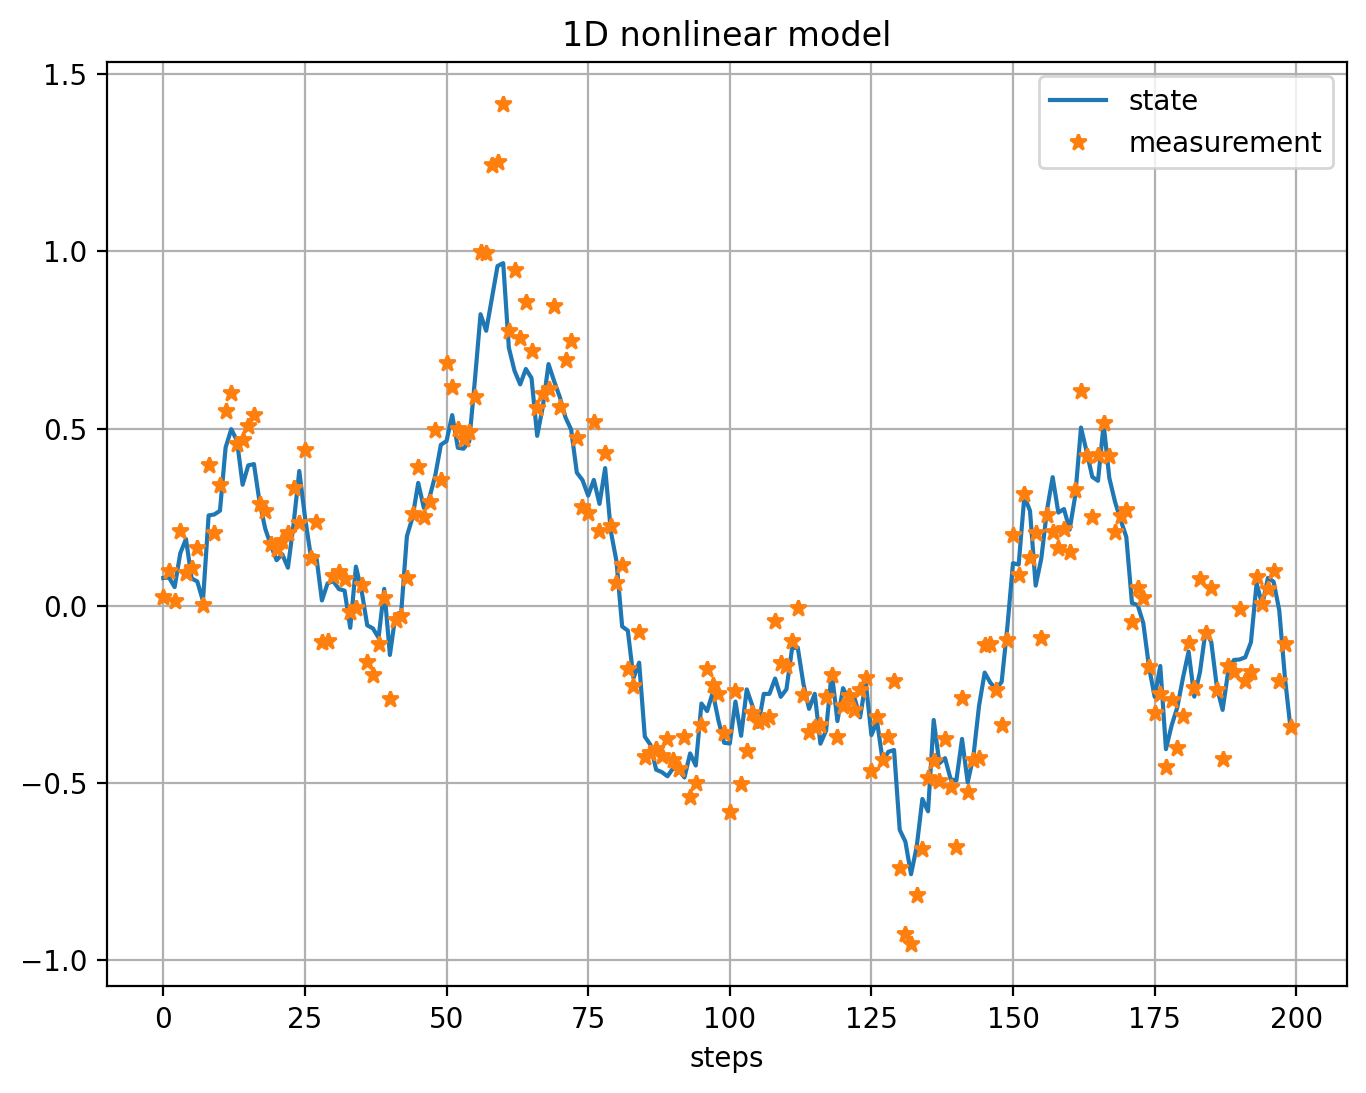

In [31]:
xs, ys = model_simulation(F, H, 200)
plt.figure(figsize=(8, 6))
plt.plot(xs, label='state')
plt.plot(ys, '*', label='measurement')
plt.title('1D nonlinear model')
plt.xlabel('steps')
plt.legend()
plt.grid()

In [29]:
# Derivatives using autograd
Fx, Hx = grad(F), grad(H)

#### Extended Kalman Filter

The extended kalman filter state estimation for a 1D nonlinear state-space model

In [30]:
def extended_kalman_filter_1d(Y):
    """
    Input:
        Y: measurements
    Output:
        mean_ekf = mean estimate
        cov_ekf = covariance estimate 
    """

    steps = Y.shape[0]

    mean_ekf, cov_ekf = np.zeros((steps, 1)), np.zeros((steps, 1, 1))

    m = Y[0]
    P = random_normal(0, 0.1)
    Q, R = 0.1**2, 0.1**2
    
    for i in range(steps):
        # prediction
        m_ = m
        fx, hx = Fx(m_), Hx(m_)
        P_ = (fx ** 2) * P + Q
        
        # update
        K = (P_ * hx)/(hx * hx * P_ + R)
        m = m_ + K * (Y[i] - H(m_))
        P = P_ - K*K * (hx * hx * P_ + R)
        
        mean_ekf[i] = m
        cov_ekf[i] = P
    return mean_ekf, cov_ekf # do not change this line

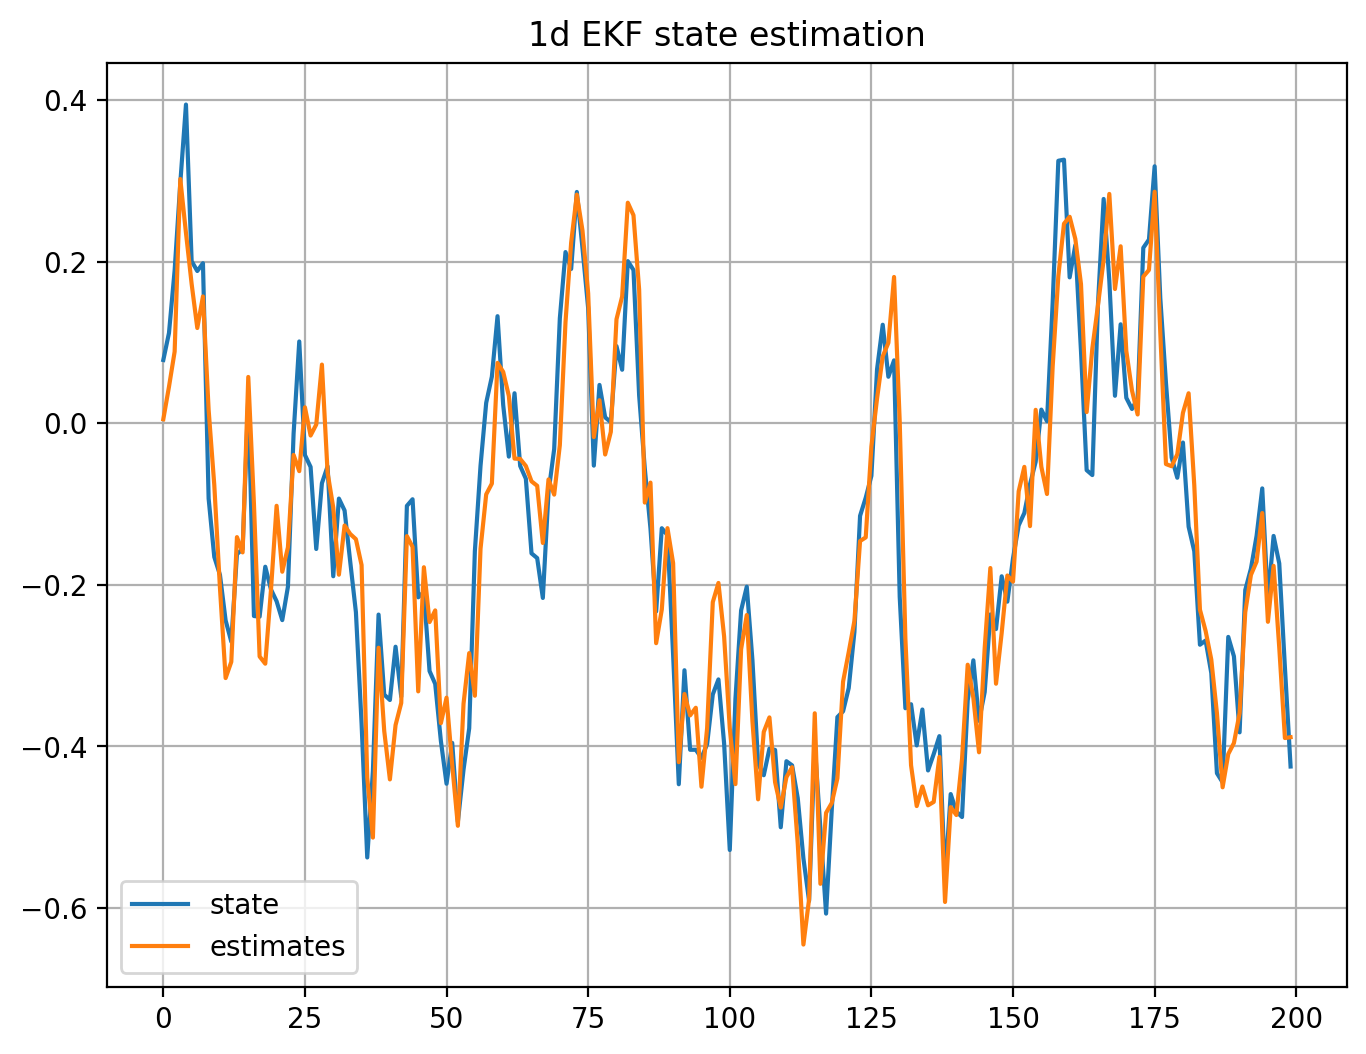

In [27]:
observations = ys
x_ekf, cov_ekf = extended_kalman_filter_1d(observations)
plt.figure(figsize=(8, 6))
plt.plot(xs, label='state')
# plt.plot(ys, label='measurements')
plt.plot(x_ekf, label='estimates')
plt.title('1d EKF state estimation')
plt.legend()
plt.grid()